# Imports

In [ ]:
#@title
%%capture
!pip install jax-md

In [ ]:
#@title
import time 
import functools
import numpy as onp
import jax.numpy as jnp
from jax.scipy import ndimage
from jax import jit, grad, value_and_grad, tree_map, vmap, random, lax, ops, remat
from jax.example_libraries import optimizers
from jax_md import space, minimize, simulate, energy, quantity, smap, dataclasses, rigid_body

from jax.config import config
config.update('jax_enable_x64', True)

import matplotlib.pyplot as plt

# Designing transition rates

Reference: https://doi.org/10.1073/pnas.2024083118 

Controlled rates of transitions between states are critical to processes ranging from protein folding to transmembrane transport. Measuring transition rates informs our understanding of these complex functionalities. The previous section discussed the Doubly-Nudged Elastic Band (DNEB) method, which estimates the transition between distinct configurations of particles and enables measurements of the transition rate.

Jax-MD, however, enables us to go much further than just measuring transition rates. Designing for functions such as transmembrane transport relies on the ability to *control* transition rates, not simply measure them. By differentiating over measurements, we can directly design transition rates between colloidal particles.




## Set up particle configurations

Let's start out by defining the two states we're transitioning between. Here are two ground state colloidal clusters consisting of seven particles. I'm going to provide sets of positions, but any pair of ground state (minimum energy) configurations with a single energy barrier between them would work.

In [ ]:
N = 7 #number of particles
dim = 3 #dimension
kT = 0.3 #temperature

#3D positions of the first ground state cluster of 7 particles
R1 = jnp.array([0, 0, 0, 0.95105651629515357212, -1.3090169943749474241, 0, \
              0.95105651629515357212, 0.30901699437494742410, 0, 0, \
              -1.0000000000000000000, 0, 1.5388417685876267013, \
              -0.50000000000000000000, 0, 0.68819096023558676910, \
              -0.50000000000000000000, 0.52573111211913360603, \
              0.68819096023558676910, -0.50000000000000000000, \
              -0.52573111211913360603],dtype=jnp.float64).reshape((N,dim))


#3D positions of the second ground state cluster of 7 particles
R2 = jnp.array([1.0000000000000000000, -1.0000000000000000000, 0, 0, 0, 0, \
              1.5000000000000000000, -0.50000000000000000000, \
              0.70710678118654752440, 0, -1.0000000000000000000, 0, \
              1.0000000000000000000, 0, 0, 0.50000000000000000000, \
              -0.50000000000000000000, -0.70710678118654752440, \
              0.50000000000000000000, -0.50000000000000000000, \
              0.70710678118654752440],dtype=jnp.float64).reshape((N,dim))

# change the indices of R2 to match the positions of R1 more closely
reordering = jnp.array([1, 0, 4, 3, 2, 6, 5])
R2 = R2[reordering]

We can visualize these states below. I've included the code to look at the first state. Modify the code to look at both states.

In [ ]:
from jax_md.colab_tools import renderer

#choose a box size larger than your cluster for the renderer
box_size = 4.0 
#place the cluster at the center of the box for easier visualization
R1_recentered = R1 + box_size/2

renderer.render(box_size,
                renderer.Sphere(R1_recentered))

Now we need to tell our system how these particles are interacting. We're going to specify a morse interaction and optimize over the interaction mtarix in order to achieve the rates we want.

Once you've gone through this exercise, come back to this point and try different energy functions: how do these functions change (1) the agreement between our desired rates and the true rates and (2) the optimal interaction matrices we find?

In [ ]:
displacement, shift = space.free()

epsilon = 1. - jnp.eye(N) #interaction matrix
energy_fn = lambda dr, epsilon: energy.morse_pair(displacement, epsilon=epsilon, alpha=5.0, sigma=1.0)(dr)

## DNEB functions

### Core DNEB functions

In [ ]:
#@title
def run_minimization_while(energy_fn, R_init, shift, max_grad_thresh = 1e-12, max_num_steps=1000000, **kwargs):
  init, apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def cond_fn(val):
    state, i = val
    return jnp.logical_and(get_maxgrad(state) > max_grad_thresh, i < max_num_steps)

  @jit
  def body_fn(val):
    state, i = val
    return apply(state), i + 1

  state = init(R_init)
  state, num_iterations = lax.while_loop(cond_fn, body_fn, (state, 0))

  return state.position, get_maxgrad(state), num_iterations

def run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift,  
                                         max_grad_thresh = 1e-12, max_num_steps = 1000000, 
                                         step_inc = 1000, verbose = False, **kwargs):
  nbrs = neighbor_fn.allocate(R_init)

  init,apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def body_fn(state_nbrs, t):
    state, nbrs = state_nbrs
    nbrs = neighbor_fn.update(state.position, nbrs)
    state = apply(state, neighbor=nbrs)
    return (state, nbrs), 0
  
  state = init(R_init, neighbor=nbrs)
  
  step = 0
  while step < max_num_steps:
    rtn_state, _ = lax.scan(body_fn, (state, nbrs), step + jnp.arange(step_inc))
    new_state, nbrs = rtn_state
    # If the neighbor list overflowed, rebuild it and repeat part of 
    # the simulation.
    if nbrs.did_buffer_overflow:
      print('Buffer overflow. Reallocating...')
      nbrs = neighbor_fn.allocate(state.position)
    else:
      state = new_state
      step += step_inc
      if get_maxgrad(state) <= max_grad_thresh:
        break

  if verbose:
    print('Minimized the energy in {} minimization loops ({} steps each) and reached a final \
maximum gradient of {}'.format(step//step_inc, step_inc, get_maxgrad(state)))

  return state.position, get_maxgrad(state), nbrs, step
  
def interpolate_positions(R1, R2, num_images, displacement, shift):
  """ Create images that span between R1 and R2

  Args:
    R1: array of shape (N,d) 
    R2: array of shape (N,d) 
    num_images: int indicating number of total images to be returned
    displacement: jax_md displacement function
    shift: jax_md shift function

  Return: array of shape (num_images, N, d) 
  """
  system_displacement = vmap(displacement, in_axes=(0,0))
  dr = system_displacement(R2, R1)
  
  #linear interpolation 
  return jnp.array([ shift(R1, i * dr) for i in jnp.linspace(0, 1, num_images)])

In [ ]:
#@title
def setup_DNEB_force(true_energy_fn, spring_energy_fn, displacement):
  """ Defines Doubly Nudged Elastic Band calculations

  Args:
    true_energy_fn:  A function that takes an (N,d) array of positions and 
      returns an energy. 
    spring_energy_fn: A function that takes an (m,N,d) array of positions and 
      returns an energy (corresponding to the springs that couple the m systems)
    displacement: jax_md displacement function

  """

  multi_system_displacement = vmap(vmap(
    displacement, in_axes=(0,0)), in_axes=(0,0))

  true_energy_full_fn = vmap(true_energy_fn)
  true_gradient_full_fn = vmap(grad(true_energy_fn))
  spring_gradient_fn = grad(spring_energy_fn)

  true_energy_full_fn = jit(true_energy_full_fn)
  true_gradient_full_fn = jit(true_gradient_full_fn)
  spring_gradient_fn = jit(spring_gradient_fn)

  def calculate_tau_hat(R):
    energies = true_energy_full_fn(R)
    dE = energies[1:] - energies[:-1]  #E(i+1) - E(i) for all i
    #energy differences of neighbors i-1, i, and i+1
    dEr = dE[1:]  #E(i+1) - E(i)
    dEl = dE[:-1]  #E(i) - E(i-1)
    #maximum/minimum values
    dEmax = jnp.maximum(jnp.abs(dEr), jnp.abs(dEl))
    dEmin = jnp.minimum(jnp.abs(dEr), jnp.abs(dEl))

    #case separation: write down and normalize all 4 different tangent vectors (all have same length)
    #tau0 & tau1 are cases in which eq. (4) from DNEB paper can be applied
    #tau0 = R[2:] - R[1:-1]  #R(i+1)-R(i)
    tau0 = multi_system_displacement(R[1:-1], R[2:])
    #tau1 = R[1:-1] - R[:-2]  #R(i)-R(i-1)
    tau1 = multi_system_displacement(R[:-2], R[1:-1])
    #tau2 & tau3 are cases in which eq. (4) cannot be applied, i.e., image i is at a minimum/maximum
    #compute weighted average of the vectors to the two neighboring images, eqs. (10)+(11) from G. Henkelman and H. Jónsson, J. Chem. Phys. 113, 9978 (2000)
    tau2 = vmap(jnp.dot)(tau0, dEmax) + vmap(jnp.dot)(tau1, dEmin)
    tau3 = vmap(jnp.dot)(tau0, dEmin) + vmap(jnp.dot)(tau1, dEmax)
    #normalization
    tau0 = tau0 / jnp.linalg.norm(tau0, axis=(1, 2), keepdims=True)
    tau1 = tau1 / jnp.linalg.norm(tau1, axis=(1, 2), keepdims=True)
    tau2 = tau2 / jnp.linalg.norm(tau2, axis=(1, 2), keepdims=True)
    tau3 = tau3 / jnp.linalg.norm(tau3, axis=(1, 2), keepdims=True)

    #4 cases
    v0 = jnp.array(
        jnp.logical_and(dEl > 0, dEr > 0), dtype=jnp.int32)  #E(i+1)>E(i)>E(i-1)
    v1 = jnp.array(
        jnp.logical_and(dEl < 0, dEr < 0), dtype=jnp.int32)  #E(i+1)<E(i)<E(i-1)
    v2 = jnp.array(
        jnp.logical_and((v0 + v1) != 1, (dEr + dEl) > 0),
        dtype=jnp.int32)  #min/max and E(i+1)>E(i-1)
    v3 = jnp.array(
        jnp.logical_and((v0 + v1) != 1, (dEr + dEl) < 0),
        dtype=jnp.int32)  #min/max and E(i+1)<E(i-1)
    v = 0 * v0 + 1 * v1 + 2 * v2 + 3 * v3  #index array, tells for each element, which of the taus to choose

    choices = jnp.array([tau0, tau1, tau2, tau3])  #set of arrays to choose from
    tau = jnp.array(
        vmap(lambda choices, v: choices[v], in_axes=(1, 0))(choices, v))
    return tau

  #non-normalized projection of a onto b.
  # for this to be a proper projection, b should already be normalized
  def projection(a, b):
    return jnp.tensordot(a, b) * b

  vmap_projection = vmap(projection)

  def total_force(Rs):
    g = true_gradient_full_fn(Rs)[1:-1]
    gtilde = spring_gradient_fn(Rs)[1:-1]
    tauhat = calculate_tau_hat(Rs)

    #split the true potential up into parallel and perpendicular parts
    g_parallel = vmap_projection(g, tauhat)
    g_perp = g - g_parallel

    #split the spring potential up into parallel and perpendicular parts
    gtilde_parallel = vmap_projection(gtilde, tauhat)
    gtilde_perp = gtilde - gtilde_parallel

    #calculate gtilde_star via eq. (13). this is the "second nudge"
    g_perp_hat = g_perp / jnp.linalg.norm(g_perp, axis=(1, 2), keepdims=True)
    gtilde_star = gtilde_perp - vmap_projection(gtilde_perp, g_perp_hat)

    #get the total gradient via eq. (12) with some parts (g_parallel and gtilde_perp) projected out
    gtotal = g_perp + gtilde_parallel + gtilde_star

    #put zeros at the beginning and end, and multiply by -1 to make the gradient a force
    temp = jnp.zeros((1,) + tauhat[0].shape, dtype=Rs.dtype)
    return -jnp.concatenate((temp, gtotal, temp))

  return total_force

def setup_DNEB_minimization(true_energy_fn,
                            spring_energy_fn,
                            displacement_fn,
                            shift_fn,
                            dt_start=0.0001,
                            dt_max=0.0004,
                            num_images=100,
                            max_grad_thresh=1e-12,
                            max_num_steps=100000,
                            return_dneb_force_fn=False):
  """ Define a function to minimize a DNEB
  """

  true_energy_full_fn = vmap(true_energy_fn)

  total_force = setup_DNEB_force(true_energy_fn, spring_energy_fn, displacement_fn)
  total_force = jit(total_force)

  fire_init, fire_apply = minimize.fire_descent(
      total_force, vmap(shift_fn), dt_start=dt_start, dt_max=dt_max)
  fire_apply = jit(fire_apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def cond_fn(val):
    state, i = val
    return jnp.logical_and(
        get_maxgrad(state) > max_grad_thresh, i < max_num_steps)

  @jit
  def body_fn(val):
    state, i = val
    return fire_apply(state), i + 1

  def minimize_DNEB(R_input, verbose=False):
    """ minimize a DNEB

    Args: 
      R_input: list or array of shape (n, N, d)
        If n==2, these are taken to be DNEB endpoints and image states are 
          generated using linear interpolation
        If n>2, these are taken to be the full DNEB path

      Return: (Rfinal, Efinal)
        Rfinal: an array of shape (num_images, N, d) or (n, N, d) 
          giving the positions of all images as found by the DNEB
        Efinal: array of shape (num_images,) or (n,) giving the true 
          energy of each image
    """
    R_input = jnp.array(R_input)
    if R_input.shape[0] > 2:
      Rinit = R_input
    elif R_input.shape[0] == 2:
      R1 = R_input[0]
      R2 = R_input[1]
      Rinit = interpolate_positions(R1, R2, num_images, displacement_fn, shift_fn)
    else:
      assert False

    state = fire_init(Rinit)
    state, num_iterations = lax.while_loop(cond_fn, body_fn, (state, 0))

    if verbose:
      print('finished minimizing dneb. max_grad = {}, num_iter = {}'.format(jnp.amax(jnp.abs(state.force)), num_iterations))

    Rfinal = state.position
    Efinal = true_energy_full_fn(Rfinal)

    return Rfinal, Efinal 

  if return_dneb_force_fn:
    return minimize_DNEB, total_force
  else:
    return minimize_DNEB

### DNEB for transition states

Now that we have our states and an energy function, we can use DNEB to estimate the transition between the states. The details of the DNEB calculation are given earlier in this workshop.

In [ ]:
mapped_displacement = vmap(vmap(displacement, in_axes = (0,0)), in_axes = (0,0))

def spring_energy_fn(Rall, k_spring=0.2):
  """ Calculate the coupling energy that couples neighboring images
  """
  return k_spring * jnp.sum( mapped_displacement(Rall[:-1], Rall[1:]) ** 2)


def run_DNEB(R_endpoints, interaction_matrix, dneb_spring_const = 0.2,
             num_images=50, max_num_steps=10000, dt_start=0.0001, 
             dt_max=0.0004):
  
  minimize_DNEB = setup_DNEB_minimization(lambda R: energy_fn(R, interaction_matrix),
                                          lambda R: spring_energy_fn(R, dneb_spring_const),
                                          displacement,
                                          shift,
                                          dt_start = dt_start,
                                          dt_max = dt_max,
                                          num_images = num_images,
                                          max_num_steps = max_num_steps,
                                          return_dneb_force_fn=False
                                          )
  
  DNEB_results_all = minimize_DNEB(R_endpoints, False)
  return DNEB_results_all


endpoints = jnp.array([R1, R2])
DNEB_results = run_DNEB(endpoints, epsilon)
path_positions, path_energies = DNEB_results

You can use the same renderer above to look at the predicted transition path positions:

In [ ]:
box_size = 4.0 
#place the cluster at the center of the box for easier visualization
pos = path_positions + box_size/2

renderer.render(box_size,
                renderer.Sphere(pos))

## Define order parameter: transition rate

The last thing we need in order to do our optimization is an estimate of the transition rate. We're going to use transition state theory to get a rough estimate of the transition rates, given that we now know the energy of the transition barrier. Let the energy of the transition state be $E_t$, the energy of the first state be $E_1$, and the energy of the second state be $E_2$. Then, we estimate the transition rate from state $1$ to state $2$ to be:

$k_{12} = e^{-(E_t - E_1)/k_BT}$

and the transition rate from state 2 to state 1 is:

$k_{21} = e^{-(E_t - E_2)/k_BT}$



In [ ]:
def calc_transition_rate(energies, kT=0.1):
  Et = jnp.max(energies)
  E1 = energies[0]
  E2 = energies[-1]
  fwd_rate = jnp.exp(-(E1 - Et)/kT)
  rev_rate = jnp.exp(-(E2 - Et)/kT)
  return fwd_rate - rev_rate

We can now estimate the forward and reverse transition rates in our system:

In [ ]:
calc_transition_rate(path_energies, kT)

DeviceArray(18.59547493, dtype=float64)

We finally have all the pieces we need to optimize for the transition rate we want. 

Suppose we want to increase our forward transition rate from _____ to _____. We can define a loss function that minimizes the squared difference between the measured transition rate and the target transition rate:

In [ ]:
target_rate = 100.0 

@jit
def compute_path(interaction_matrix, endpoints):
  DNEB_results = run_DNEB(endpoints, interaction_matrix)
  path_positions, path_energies = DNEB_results
  return path_positions, path_energies

@jit
def compute_loss(interaction_matrix, target_rate, path_positions):
  path_energies = vmap(energy_fn, (0, None))(path_positions, interaction_matrix)
  measured_rate = calc_transition_rate(path_energies, kT)
  return (target_rate - measured_rate)**2

## Optimize

To optimize, we can simply compute the gradient of our loss function and update the interaction matrix accordingly. We're going to take advantage of the built-in optimizers jax offers to make this easier

In [ ]:
grad_compute_loss = value_and_grad(compute_loss, 0)

In [ ]:
opt_steps = 100
lr_steps = opt_steps // 3
learning_rates = jnp.array([0.01] * lr_steps + [0.001] * 2*lr_steps)
learning_rate = lambda t: learning_rates[t]

# Choose an optimizer (or write your own!)
opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)

'''
Given the current state of an optimizer and the gradient, update the parameters
'''
def opt_step(i, opt_state, endpoints):
    params = get_params(opt_state)
    lossval, gradval = grad_compute_loss(params, target_rate, path_positions)
    print("Loss: {}".format(lossval))
    # print("Parameters: {}".format(params))
    # print("Gradient: {}".format(gradval))
    return opt_update(i, gradval, opt_state), params, lossval

In [ ]:
opt_state = opt_init(epsilon) 
endpoints = jnp.array([R1, R2])
params = epsilon
best_params = params
min_loss = jnp.inf

for i in range(opt_steps):
  # Recompute the DNEB path periodically rather than every step
  # to save compute time
  if i % 5 == 0:
      path_positions, path_energies, compute_path(params, endpoints)
      endpoints = jnp.array([path_positions[0], path_positions[-1]]) 
  opt_state, new_params, loss = opt_step(i, opt_state, endpoints)
  if loss < min_loss:
    min_loss = loss
    best_params = params
  params = new_params

  if i % (opt_steps // 3) == 0:
    opt_state = opt_init(best_params)
    params = best_params

print('Minimum loss value: ', min_loss)

Loss: 6626.696701640181
Loss: 6626.696701640181
Loss: 6444.162569492445
Loss: 6228.032707262258
Loss: 5992.3494679553805
Loss: 5732.54195183322
Loss: 5457.498526250248
Loss: 5169.469065415491
Loss: 4869.34438704274
Loss: 4557.899805882532
Loss: 4235.958352614498
Loss: 3901.222087298573
Loss: 3545.8784793554223
Loss: 3182.6519582327405
Loss: 2814.030489165538
Loss: 2443.191866253231
Loss: 2074.1515546446103
Loss: 1710.5585014009146
Loss: 1345.4176860193272
Loss: 1002.1436645540658
Loss: 691.0532805953721
Loss: 423.8548941387887
Loss: 213.00959924268886
Loss: 69.59806456217008
Loss: 3.051293568215733
Loss: 22.39159884550615
Loss: 115.70152655326476
Loss: 253.3295817355749
Loss: 392.6900677004523
Loss: 492.63071743773645
Loss: 528.9005218950608
Loss: 499.9557628455604
Loss: 421.76793989375983
Loss: 318.0697522165387
Loss: 69.59806456217008
Loss: 62.92437536376943
Loss: 54.363764142878416
Loss: 45.05762889393
Loss: 35.73202749975623
Loss: 26.917166337484012
Loss: 19.013968662319975
Loss: 1

Does the interaction matrix change in ways you expected? How do the optimization results change when you change the learning rate? The initial states? The energy function?

We can also ask what range of transition rates we can actually design: play with the target rate and get a feel for the designability of this system.

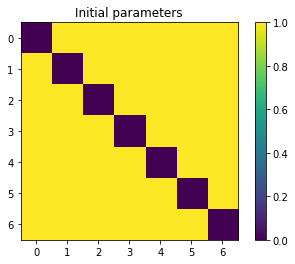

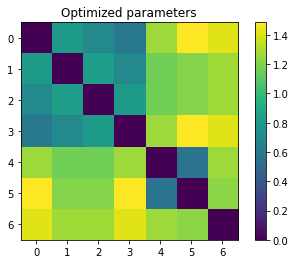

In [ ]:
plt.imshow(epsilon)
plt.title('Initial parameters')
plt.colorbar()
plt.show()

plt.imshow(best_params)
plt.title('Optimized parameters')
plt.colorbar()
plt.show()


In [ ]:
box_size = 4.0 
#place the cluster at the center of the box for easier visualization
pos = path_positions + box_size/2

renderer.render(box_size,
                renderer.Sphere(pos))

# Shape optimization: stabilizing a square lattice

In addition to optimizing over interactions, we can design the *shapes* of the particles themselves. To demonstrate the capacity to optimize over particle shapes, we're going to consider the example of patchy particles.

Here, we're considering patchy particles to be isotropic particles that interact repulsively that have interacting patches rigidly attached to their surface. We're going to optimize over the positions of the interacting patches.


In this example, we're going to design 2D patchy particles that stabilize a squrae lattice.

## Define the lattice configuration

The goal of this section is to design particles that can stabilize a square lattice. We're going to initialize $N$ particles into a square lattice configuration. The initial parameter values for those particles will cause the lattice to melt. We will optimize to find parameters that can stabilize the lattice, so it doesn't melt!

As a first step, let's define a square lattice.

In [ ]:
'''
Takes in a number of particles to lie on the edge of the lattice: L=10 will return
a 10x10 lattice of 100 particles total. Returns x-y coordinates for a square lattice
'''
def sq(L):
  square = onp.zeros((L*L, 2))
  for i in range(L):
    square[i*L:(i+1)*L, 0] = onp.arange(0, L, 1)
    square[i*L:(i+1)*L, 1] = onp.full(L, i)
  return square


# We're going to look at a lattice composed of 25 particles
N = 25
L = jnp.int32(jnp.sqrt(N))
square_lattice = sq(L)

We can visualize the lattice and make sure it looks how we expect:

(-0.2, 4.2, -0.2, 4.2)

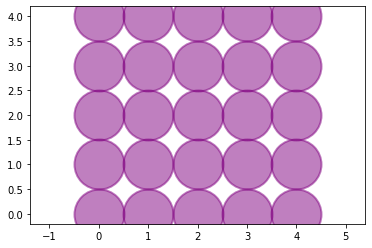

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(square_lattice[:, 0], square_lattice[:, 1], s=2500, alpha=0.5, linewidth=2, color='purple')
plt.axis('equal')

In order to stabilize a square lattice, we're going to use patchy particles. The patches can represent bonds, which means we can employ non-isotropic interactions to stabilize this lattice. 

Eventually we're going to optimize over these non-isotropic interactions, but for now, let's choose one set of interactions and run a short simulation. Since we want to stabilize a square lattice, let's use four patches to represent bonds with the four nearest neighbors of each particle in the lattice. 

In [ ]:
'''We'll start with a set of angles for the placement of each patch. We're going to 
convert those angles into x-y positions relative to a central particle, and then 
return a "shape", which is an object that represents the full patchy particle as 
a rigid body.'''
fixed_thetas=jnp.array([3*jnp.pi/2, jnp.pi, jnp.pi/2])

@jit
def thetas_to_shape(thetas, radius=0.5, center_mass=1.0):
  # Convert angles to patch positions
  patch_positions = jnp.zeros((len(thetas), 2), dtype = jnp.float64)
  patch_positions = patch_positions.at[:,0].set(radius*jnp.cos(thetas))
  patch_positions = patch_positions.at[:,1].set(radius*jnp.sin(thetas))

  # Add the central particle (position (0, 0)) to the list of positions
  central_particle_position = jnp.array([[0.0, 0.0]])
  positions = jnp.concatenate((central_particle_position, patch_positions), axis=0)

  # To enable each patch to interact separately, assign them each separate species
  species = jnp.arange(len(thetas) + 1)
  species = jnp.array(species, dtype = jnp.int32)

  # Combine positions and species to form a patchy particle rigid_body object
  patch_mass = 0.00001
  masses = jnp.array([center_mass] + len(thetas)*[patch_mass])
  shape = rigid_body.point_union_shape(positions, masses).set(point_species=species)
  return shape

Let's look at how these patchy particles look in our square lattice configuration:

In [ ]:
# Choose a random set of angles
key = random.PRNGKey(0)
thetas = random.uniform(key, (4,), minval=0.0, maxval=2*jnp.pi)

# Conver to rigid body object
patchy_particle_shape = thetas_to_shape(thetas)

# Choose random orientations for each patchy particle
angle_key, split = random.split(key)
orientations = random.uniform(angle_key, (N,), dtype=jnp.float64) * jnp.pi * 2

# Combine orientations with square lattice positions
full_configuration = rigid_body.RigidBody(square_lattice, orientations)

In [ ]:
'''Helper function that lets us easily
   plot our patchy particles'''
def body_to_plot(body, thetas):
  shape = thetas_to_shape(thetas, radius=0.5)
  body_pos = vmap(rigid_body.transform, (0, None))(body, shape)
  bodypos = body_pos.reshape(-1, 2)
  species_list = jnp.array(list(jnp.arange(len(thetas)+1)) * len(body.center))

  inds_at_id = lambda id: jnp.squeeze(jnp.argwhere(species_list==id))
  center_particles = bodypos[inds_at_id(0)]
  list_of_patch_particles = []
  for i in range(1, len(thetas)+1):
    list_of_patch_particles += [bodypos[inds_at_id(i)]]

  return center_particles, list_of_patch_particles

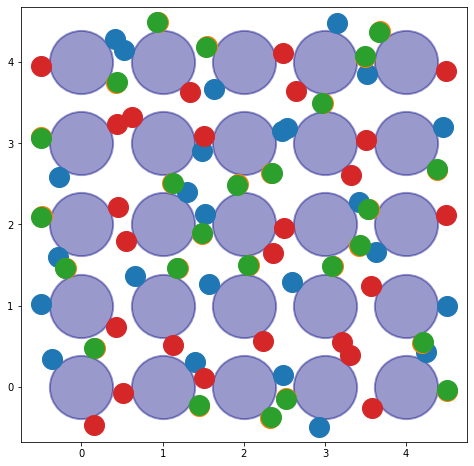

In [ ]:
center_pos, patches_pos = body_to_plot(full_configuration, thetas)

plt.scatter(center_pos[:, 0], center_pos[:, 1], s=4000, color='navy', alpha=0.4, linewidth=2)

for p in patches_pos:
  plt.scatter(p[:, 0], p[:, 1], s=400, alpha=1.0)
plt.axis('equal')


fig = plt.gcf()
fig.set_size_inches(8.0, 8.0)

## Experiment with the system through forward simulation

Now let's run a short simulation: do these patches stabilize the lattice, or will it melt?

In [ ]:
# Let's first set some basic parameters

kT = 0.001 #temperature
dt = 1e-3 #simulation step size
density = 0.5 #number density
dim = 2 #dimension
num_steps = 1000 #number of simulation steps
box_size = 5.0#quantity.box_size_at_number_density(N, density, dim)

displacement, shift = space.periodic(box_size)



'''
Define an energy function for our system. We'll allow patches to overlap
   so they act more like bonds'''
soft_sphere_eps = jnp.zeros((len(thetas) + 1, len(thetas) + 1))
soft_sphere_eps = soft_sphere_eps.at[0, 0].set(1.0)
morse_eps = jnp.eye(len(thetas)+1) - soft_sphere_eps
soft_sphere_eps = 10000*soft_sphere_eps
morse_eps = 4.0*morse_eps
pair_energy_soft = energy.soft_sphere_pair(displacement, species=1+len(thetas), sigma=1.0, epsilon=soft_sphere_eps, alpha=4.0)
pair_energy_morse = energy.morse_pair(displacement, species=1+len(thetas), sigma=0.0, epsilon=morse_eps, alpha=9.0, r_cutoff=1.5)
pair_energy_fn = lambda R, **kwargs: pair_energy_soft(R, **kwargs) + pair_energy_morse(R, **kwargs)
energy_fn = rigid_body.point_energy(pair_energy_fn, patchy_particle_shape)

In [ ]:
# Set up simulation environment in the usual way
init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)
step_fn = jit(step_fn)
state = init_fn(key, full_configuration, mass=patchy_particle_shape.mass())


# run simulation!
do_step = lambda state, t: (step_fn(state), energy_fn(state.position))
steps = jnp.arange(num_steps)
state, energies = lax.scan(do_step, state, steps)

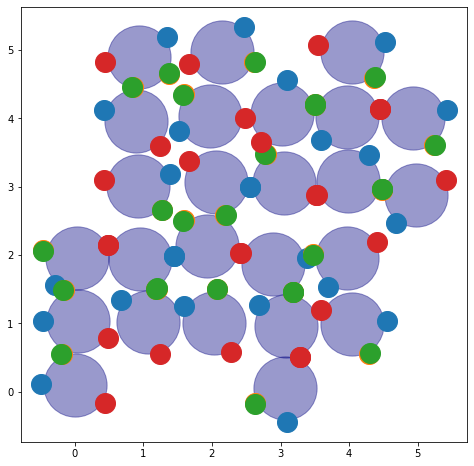

In [ ]:
# Plot the output of the simulation:
center_pos, patches_pos = body_to_plot(state.position, thetas)
plt.scatter(center_pos[:, 0], center_pos[:, 1], s=4000, color='navy', alpha=0.4)

for p in patches_pos:
  plt.scatter(p[:, 0], p[:, 1], s=400)
plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(8.0, 8.0)

## Define a loss function (order parameter)

We can see that the final configuration of the particles is no longer a perfect square lattice. The particles are still in an aggregate, but they've lost some of their order. 

In order to optimize this system to stay in the square lattice configuration, we need a way to measure how well the particles have maintained their configurational order. We're going to use a standard order parameter that detects crystal symmetries: the bond orientational order parameter with quadratic symmetry (because the square lattice has quadratic symmetry).

We're ultimately going to use this as a loss function, so we're going to have the opposite sign convention of the usual BOO parameter: smaller (more negative) values are more ordered.

In [ ]:
def get_psi_k_function(displacement_all,k):
  
  #return a weight 
  def weight(r):
    sigma = 0.2 #0.05 #CPG: The actual value here will probably need to be played with...
    mu=1.0
    return jnp.where(r<1e-7, 0., jnp.exp(-(r - mu)**2/(2*sigma**2)))
  
  def weight_with_nnn(r):
    sigma = 0.2
    mu_1 = 1.0
    mu_2 = jnp.sqrt(3)
    return jnp.where(r<1e-7, 0., jnp.exp(-(r - mu_1)**2/(2*sigma**2))) + jnp.where(r<1e-7, 0., jnp.exp(-(r - mu_2)**2/(2*sigma**2)))

  
  #return the exponential part of the order parameter
  i_imaginary = complex(0,1)

  def order(dR_ij):
    epsilon = 0.0001 #avoids nan in derivative at x, y = [0, 0]
    theta_ij = jnp.arctan2(dR_ij[1] + epsilon, dR_ij[0] + epsilon)
    return jnp.exp(i_imaginary*k*theta_ij) #Note: for JAX reasons, I had to separate the i_imaginary

  
  #Map order onto a matrix
  order_all = vmap(vmap(order)) #order_all now applies to every vector in a matrix
  
  #return the complex psi_k calculated for each particle
  def psi_k_i(R):
    dR = displacement_all(R,R) #This returns a NxNx2 array of vectors between particles that respect periodic boundary conditions
    dRlen = space.distance(dR) #This is a NxN array of distances
    w = weight(dRlen)
    o = order_all(dR)
    wo = jnp.multiply(w,o) 
    return jnp.sum(wo, axis=0)/jnp.sum(w,axis=0)

  def psi_k(R):
    return jnp.mean(jnp.abs(psi_k_i(R)))

  return psi_k

In [ ]:
displacement, shift = space.periodic(box_size)
displacement_all = space.map_product(displacement)
psi4 = get_psi_k_function(displacement_all,4)
print(psi4(square_lattice))

0.7903382362276845


## Define functions to optimize over

We'd like to use this metric as an order parameter, or equivalently as a loss function, for our system. In this case, we have a guess at what we think the optimal value for our thetas will be: in a square lattice, the four angles should be equally spaced, 90 degrees apart. So, we can compare our random orientation result to our estimate of the optimal value and check whether this order parameter will work for our design problem.

To make the optimization more convenient, we're going to put the procedure above into a function we can call easily.

In [ ]:
num_inner_steps = jnp.int32(jnp.sqrt(num_steps))

@jit
def run_simulation(thetas, key):
  # Define our rigid body objects with random initial orientations
  patchy_particle_shape = thetas_to_shape(thetas, center_mass=1.0)
  angle_key, split = random.split(key)
  orientations = jnp.zeros(N)#random.uniform(angle_key, (N,), dtype=jnp.float64) * jnp.pi * 2
  full_configuration = rigid_body.RigidBody(square_lattice, orientations)

  displacement, shift = space.periodic(box_size)

  # Define an energy function for our system. We'll allow patches to overlap
  # so they act more like bonds
  soft_sphere_eps = jnp.eye(len(thetas)+1)
  soft_sphere_eps = soft_sphere_eps.at[0, 0].set(10000.0)
  morse_eps = jnp.array([[0., 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0]])
  morse_eps = 10.0*morse_eps
  k_com_stationary = 10

  pair_energy_soft = energy.soft_sphere_pair(displacement, species=1+len(thetas), sigma=1.0, epsilon=soft_sphere_eps, alpha=4.0)
  pair_energy_morse = energy.morse_pair(displacement, species=1+len(thetas), sigma=0.0, epsilon=morse_eps, alpha=9.0, r_cutoff=1.5)
  pair_energy_fn = lambda R, **kwargs: pair_energy_soft(R, **kwargs) + pair_energy_morse(R, **kwargs)
  keep_com_stationary = lambda rb: jnp.sum(0.5 * k_com_stationary * (rb.center - square_lattice)**2)
  energy_fn_real = rigid_body.point_energy(pair_energy_fn, patchy_particle_shape)
  energy_fn = lambda rb, **kwargs: energy_fn_real(rb, **kwargs) + keep_com_stationary(rb)

  # Set up simulation environment in the usual way
  init_fn, step_fn = simulate.nvt_nose_hoover(energy_fn, shift, dt, kT)
  step_fn = jit(step_fn)
  state = init_fn(key, full_configuration, mass=patchy_particle_shape.mass())

  inner_steps = jnp.arange(num_inner_steps)
  do_inner_step = lambda state, t: (step_fn(state), 0.)
  do_step = remat(lambda state, t: lax.scan(do_inner_step, state, inner_steps))
  state, losses = lax.scan(do_step, state, inner_steps)

  displacement_all = space.map_product(displacement)
  psi4 = get_psi_k_function(displacement_all,4)
  loss = -1*psi4(state.position.center)
  return state, loss

In [ ]:
guess_at_optimal_thetas = jnp.array([0., 3*jnp.pi/2, jnp.pi, jnp.pi/2]) #jnp.array([0., jnp.pi/2, jnp.pi, 3*jnp.pi/2])
key, split = random.split(key)
state_opt, loss_value = run_simulation(guess_at_optimal_thetas, split)
print('Loss for guess at optimal angles: ', loss_value)

Loss for guess at optimal angles:  -0.5860597491110767


In [ ]:
key, split = random.split(key)
state_rand, loss_value = run_simulation(thetas, split)
print('Loss for random angles: ', loss_value)

Loss for random angles:  -0.31062319756430046


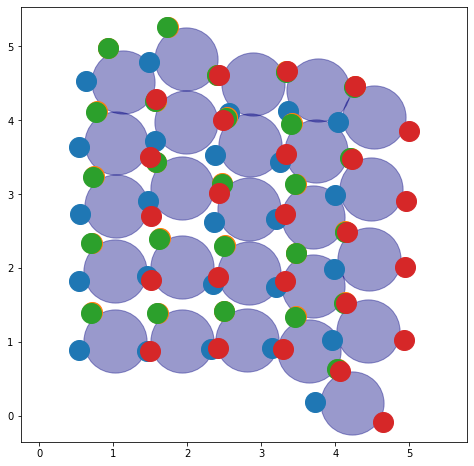

In [ ]:
#Uncomment this line to visualize the final state with guessed optimal parameters
# center_pos, patches_pos = body_to_plot(state_opt.position, guess_at_optimal_thetas)

#Uncomment this line to visualize the final state with random parameters
center_pos, patches_pos = body_to_plot(state_rand.position, thetas)
plt.scatter(center_pos[:, 0], center_pos[:, 1], s=4000, color='navy', alpha=0.4)

for p in patches_pos:
  plt.scatter(p[:, 0], p[:, 1], s=400)
plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(8.0, 8.0)

## Test batch size

This is a stochastic system, so before we try to optimize over these theta values, it's a good idea to get a sense of the variance in this loss function. The amount of variance will inform our choice of batch size

In [ ]:
batch = 10

guess_key, rand_key = random.split(key, 2)
keys_guess = random.split(guess_key, batch)
keys_rand = random.split(rand_key, batch)
v_run_simulation = vmap(run_simulation, in_axes=(None, 0))
positions_guess, losses_guess = v_run_simulation(guess_at_optimal_thetas, keys_guess)
positions_rand, losses_rand = v_run_simulation(thetas, keys_rand)

Average loss for our guesss at optimal thetas: -0.5097719121255478 +/- 0.11925135101848816
Average loss for our randomly selected thetas: -0.3385348070737233 +/- 0.031236094425464177



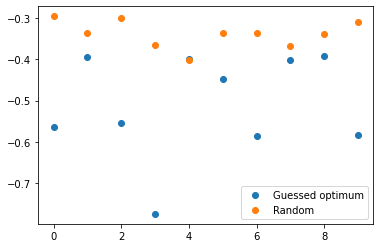

In [ ]:
print('Average loss for our guesss at optimal thetas: {} +/- {}'.format(jnp.mean(losses_guess), jnp.std(losses_guess)))
print('Average loss for our randomly selected thetas: {} +/- {}'.format(jnp.mean(losses_rand), jnp.std(losses_rand)))
print('')
step = jnp.arange(len(losses_guess))
plt.scatter(step, losses_guess, label="Guessed optimum")
plt.scatter(step, losses_rand, label="Random")
plt.legend();

We've established that our loss function is consistently lower for our (estimated) optimal values than for our randomly selected thetas.  This means we've chosen a good loss function! You can also see that the variance is fairly high, which indicates that we need a larger batch size.

Now, let's optimize over our patch positions and see if it converges to what we expect! To start, we're going to fix the positions of 3 of the 4 patches and optimize over the position of the final patch. 

## Optimize

In [ ]:
v_run_simulation = vmap(run_simulation, in_axes=(None, 0))

def mean_loss(thetas, keys):

  # We're starting out by optimizing over only one patch position and 
  # holding the rest constant. Comment out the line below to optimize 
  # over all 4 patch positions
  thetas = jnp.array([thetas[0], 3*jnp.pi/2, jnp.pi, jnp.pi/2])

  return jnp.mean(v_run_simulation(thetas, keys)[1])

grad_mean_loss = value_and_grad(mean_loss, 0)

In [ ]:
opt_steps = 20
batch_size = 50
vector_batch_size = 5
sequential_batch_size = batch_size // vector_batch_size #reduce memory usage
lr_steps = opt_steps // 3
learning_rates = jnp.array([0.1] * lr_steps + [0.1] * lr_steps + [0.01] * lr_steps)
learning_rate = lambda t: learning_rates[t]

# Choose an optimizer (or write your own!)
opt_init, opt_update, get_params = optimizers.adam(step_size=learning_rate)


@jit
def calc_gradients(grads_losses_params_key, i):
    grads, losses, params, key = grads_losses_params_key
    key, split = random.split(key)
    simulation_keys = random.split(key, vector_batch_size)
    lossval, gradval = grad_mean_loss(params, simulation_keys)
    grads = grads.at[i].set(gradval)
    losses = losses.at[i].set(jnp.mean(lossval))
    return (grads, losses, params, split), i


'''
Given the current state of an optimizer and the gradient, update the parameters
'''
def opt_step(i, opt_state, key, batch_size):
    params = get_params(opt_state)
    grads = jnp.zeros((sequential_batch_size, vector_batch_size, len(params)))
    losses = jnp.zeros((sequential_batch_size,))
    #lossval, gradval = grad_mean_loss(thetas, simulation_keys)
    grads_losses_key, _ = lax.scan(calc_gradients, (grads, losses, params, key), jnp.arange(sequential_batch_size))
    grads, losses, params, key = grads_losses_key
    lossval = jnp.mean(losses)
    gradval = jnp.mean(grads, axis=(0,1))
    # import pdb; pdb.set_trace()
    print("Loss: {}".format(lossval))
    print("Parameters: {}".format(params))
    print("Gradient: {}".format(gradval))
    return opt_update(i, gradval, opt_state), params, lossval

In [ ]:
key, split = random.split(key)
init_theta = jnp.array([0.2])
opt_state = opt_init(init_theta) 

losses = []
best_params = init_theta
min_loss = jnp.inf

for i in range(opt_steps):
  key, split = random.split(key)
  opt_state, params, loss = opt_step(i, opt_state, split, batch_size)
  losses += [loss]
  if loss < min_loss:
    min_loss = loss
    best_params = params
  if i % (opt_steps // 3)==0:
    opt_state = opt_init(best_params)

Automatic pdb calling has been turned ON
Loss: -0.44657921755075036
Parameters: [0.2]
Gradient: [0.02562269]
Loss: -0.4702748010725737
Parameters: [0.2]
Gradient: [0.02688751]
Loss: -0.5004806233368603
Parameters: [0.12558636]
Gradient: [0.033791]
Loss: -0.4870503601637215
Parameters: [0.03978447]
Gradient: [0.02811284]
Loss: -0.48524640611163683
Parameters: [-0.05082596]
Gradient: [-0.00792408]


KeyboardInterrupt: ignored

> /usr/local/lib/python3.7/dist-packages/jax/_src/dispatch.py(878)_execute_compiled()
    876       runtime_token = None
    877   else:
--> 878     out_flat = compiled.execute(in_flat)
    879   check_special(name, out_flat)
    880   out_bufs = unflatten(out_flat, output_buffer_counts)

ipdb> exit()


As the optimization converges, we see the loss decreasing and then leveling off, and we see the gradients tend towards zero. The optimization is noisy, so there are fluctuations around this trend.

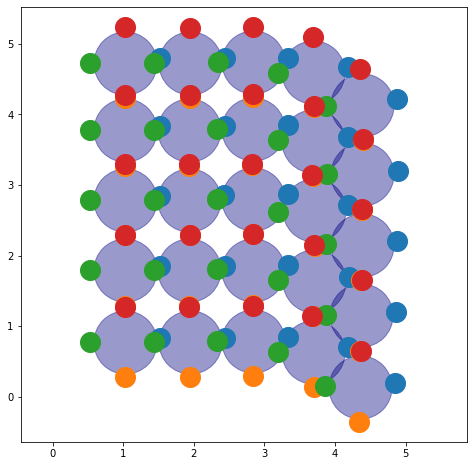

In [ ]:
key, split = random.split(key)
thetas_opt = best_params
thetas_opt = jnp.array([thetas_opt[0], 3*jnp.pi/2, jnp.pi, jnp.pi/2])
state, _ = run_simulation(thetas_opt, split)

center_pos, patches_pos = body_to_plot(state.position, thetas_opt)
plt.scatter(center_pos[:, 0], center_pos[:, 1], s=4000, color='navy', alpha=0.4)

for p in patches_pos:
  plt.scatter(p[:, 0], p[:, 1], s=400)
plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(8.0, 8.0)

Getting the optimization with all four patches (or three relative positions) to fully converge will require playing around with initial parameter values, learning rate schedules, batch sizes, and perhaps even the loss function. What improvements can you imagine making to this procedure, and what impact will changes in each of these values have on the system?

While you're playing around, you may run into a memory error. These are very common! Backpropogation through simulations is highly memory intensive. There are lots of tricks and strategies to reduce memory costs, including rematerialization and running code in sequence rather than vectorizing (at the cost of increased computation time).